In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('./high_diamond_ranked_10min.csv')
df.head(3)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5


In [3]:
df = df.drop(df.columns[0], axis = 1)    # drop the 'gameId' column
df.head(3)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5


In [4]:
df = df[df['blueWardsPlaced'] <= 50]  # drop the edge cases, wards placed > 50
df = df[df['redWardsPlaced'] <= 50]
df.shape
# drop the dependent features
df = df.drop(['blueEliteMonsters', 'blueGoldPerMin', 'redFirstBlood', 'redKills',
              'redDeaths', 'redEliteMonsters', 'redGoldDiff', 'redGoldPerMin'], axis = 1)
df.shape

(8780, 31)

In [5]:
(train, test) = train_test_split(df, train_size = 0.8, test_size=0.2, shuffle = True, stratify = df.blueWins, random_state = 0)
print(train['blueWins'].value_counts())
print(test['blueWins'].value_counts())

1    3528
0    3496
Name: blueWins, dtype: int64
1    882
0    874
Name: blueWins, dtype: int64


In [6]:
X_train = train.iloc[:, 1:]
X_test = test.iloc[:, 1:]
y_train = train.iloc[:, 0]
y_test = test.iloc[:, 0]

In [7]:
# Scaling
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
from keras.models import Sequential
from keras.layers import Dense

In [9]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

703/703 [==============================] - 1s 971us/step - loss: 0.5101 - accuracy: 0.7514
Train score: 0.510053277015686
Train accuracy: 0.751423716545105


In [10]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

********************
176/176 [==============================] - 0s 1ms/step - loss: 0.5486 - accuracy: 0.7130
Test score: 0.548590362071991
Test accuracy: 0.712984025478363


Text(0.5, 15.0, 'Predicted label')

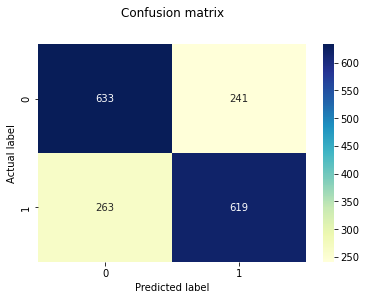

In [11]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [12]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.72      0.72       874
           1       0.72      0.70      0.71       882

    accuracy                           0.71      1756
   macro avg       0.71      0.71      0.71      1756
weighted avg       0.71      0.71      0.71      1756



In [13]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=0)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
mean = accuracies.mean()
variance = accuracies.std()

C:\Users\chenx11\AppData\Local\Temp/ipykernel_22564/2272529972.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=0)


In [14]:
print('Mean accuracy score of 10 different models using Kfold cross validation: {}'.format(mean))
print('Standard Deviation of accuracy score of 10 different models using Kfold cross validation: {}'.format(variance))

Mean accuracy score of 10 different models using Kfold cross validation: 0.7216657936573029
Standard Deviation of accuracy score of 10 different models using Kfold cross validation: 0.010122101396983078


In [15]:
# Improving the ANN
from keras.layers import Dropout
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
classifier.add(Dropout(rate = 0.1))

# Adding the second hidden layer
classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

# Part 3 - Making predictions and evaluating the model

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

703/703 [==============================] - 1s 904us/step - loss: 0.5119 - accuracy: 0.7577
Train score: 0.5118639469146729
Train accuracy: 0.7576879262924194
********************
176/176 [==============================] - 0s 983us/step - loss: 0.5517 - accuracy: 0.7067
Test score: 0.5517060160636902
Test accuracy: 0.7067198157310486


Text(0.5, 15.0, 'Predicted label')

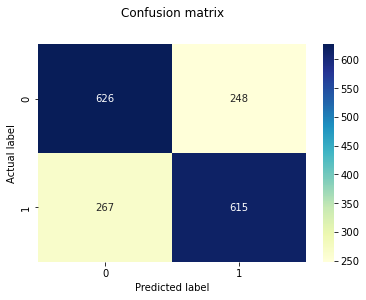

In [16]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [17]:
#import classification_report
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.72      0.71       874
           1       0.71      0.70      0.70       882

    accuracy                           0.71      1756
   macro avg       0.71      0.71      0.71      1756
weighted avg       0.71      0.71      0.71      1756



In [18]:
# Tuning the ANN
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
def build_classifier(optimizer):
    classifier = Sequential()
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu', input_dim = 30))
    classifier.add(Dense(units = 6, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [25, 32],
              'epochs': [100, 200],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(X_train, y_train,verbose = 0)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

C:\Users\chenx11\AppData\Local\Temp/ipykernel_22564/1365484947.py:13: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  classifier = KerasClassifier(build_fn = build_classifier)


In [20]:
print('Best Parameters after tuning: {}'.format(best_parameters))
print('Best Accuracy after tuning: {}'.format(best_accuracy))

Best Parameters after tuning: {'batch_size': 25, 'epochs': 100, 'optimizer': 'adam'}
Best Accuracy after tuning: 0.7269326006168112
